In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [131]:
sdir=r'D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Capstone Project/Dataset Batik0/'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths        labels
0  D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Cap...  batik-betawi
1  D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Cap...  batik-betawi
2  D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Cap...  batik-betawi
3  D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Cap...  batik-betawi
4  D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Cap...  batik-betawi
batik-celup          50
batik-parang         50
batik-betawi         48
batik-megamendung    46
batik-kawung         45
Name: labels, dtype: int64


In [132]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  191   test_df length:  24   valid_df length:  24


In [133]:
height=224
width=224
channels=3
batch_size=20

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def mobilenetv2_preprocess(img):
    # return img/127.5-1 # scale pixel between -1 and +1
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

train_aug = ImageDataGenerator(
    preprocessing_function = mobilenetv2_preprocess,
    # rescale = 1/255.0,
    shear_range = 0.2,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_aug = ImageDataGenerator(preprocessing_function = mobilenetv2_preprocess)

train_gen=train_aug.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen=ImageDataGenerator(rescale=1./255)
test_gen=test_aug.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
validgen=ImageDataGenerator(rescale=1./255)
valid_gen=train_aug.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)


classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)


test batch size:  24   test steps:  1
Found 191 validated image filenames belonging to 5 classes.
Found 24 validated image filenames belonging to 5 classes.
Found 24 validated image filenames belonging to 5 classes.
['batik-betawi', 'batik-celup', 'batik-kawung', 'batik-megamendung', 'batik-parang']


In [134]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

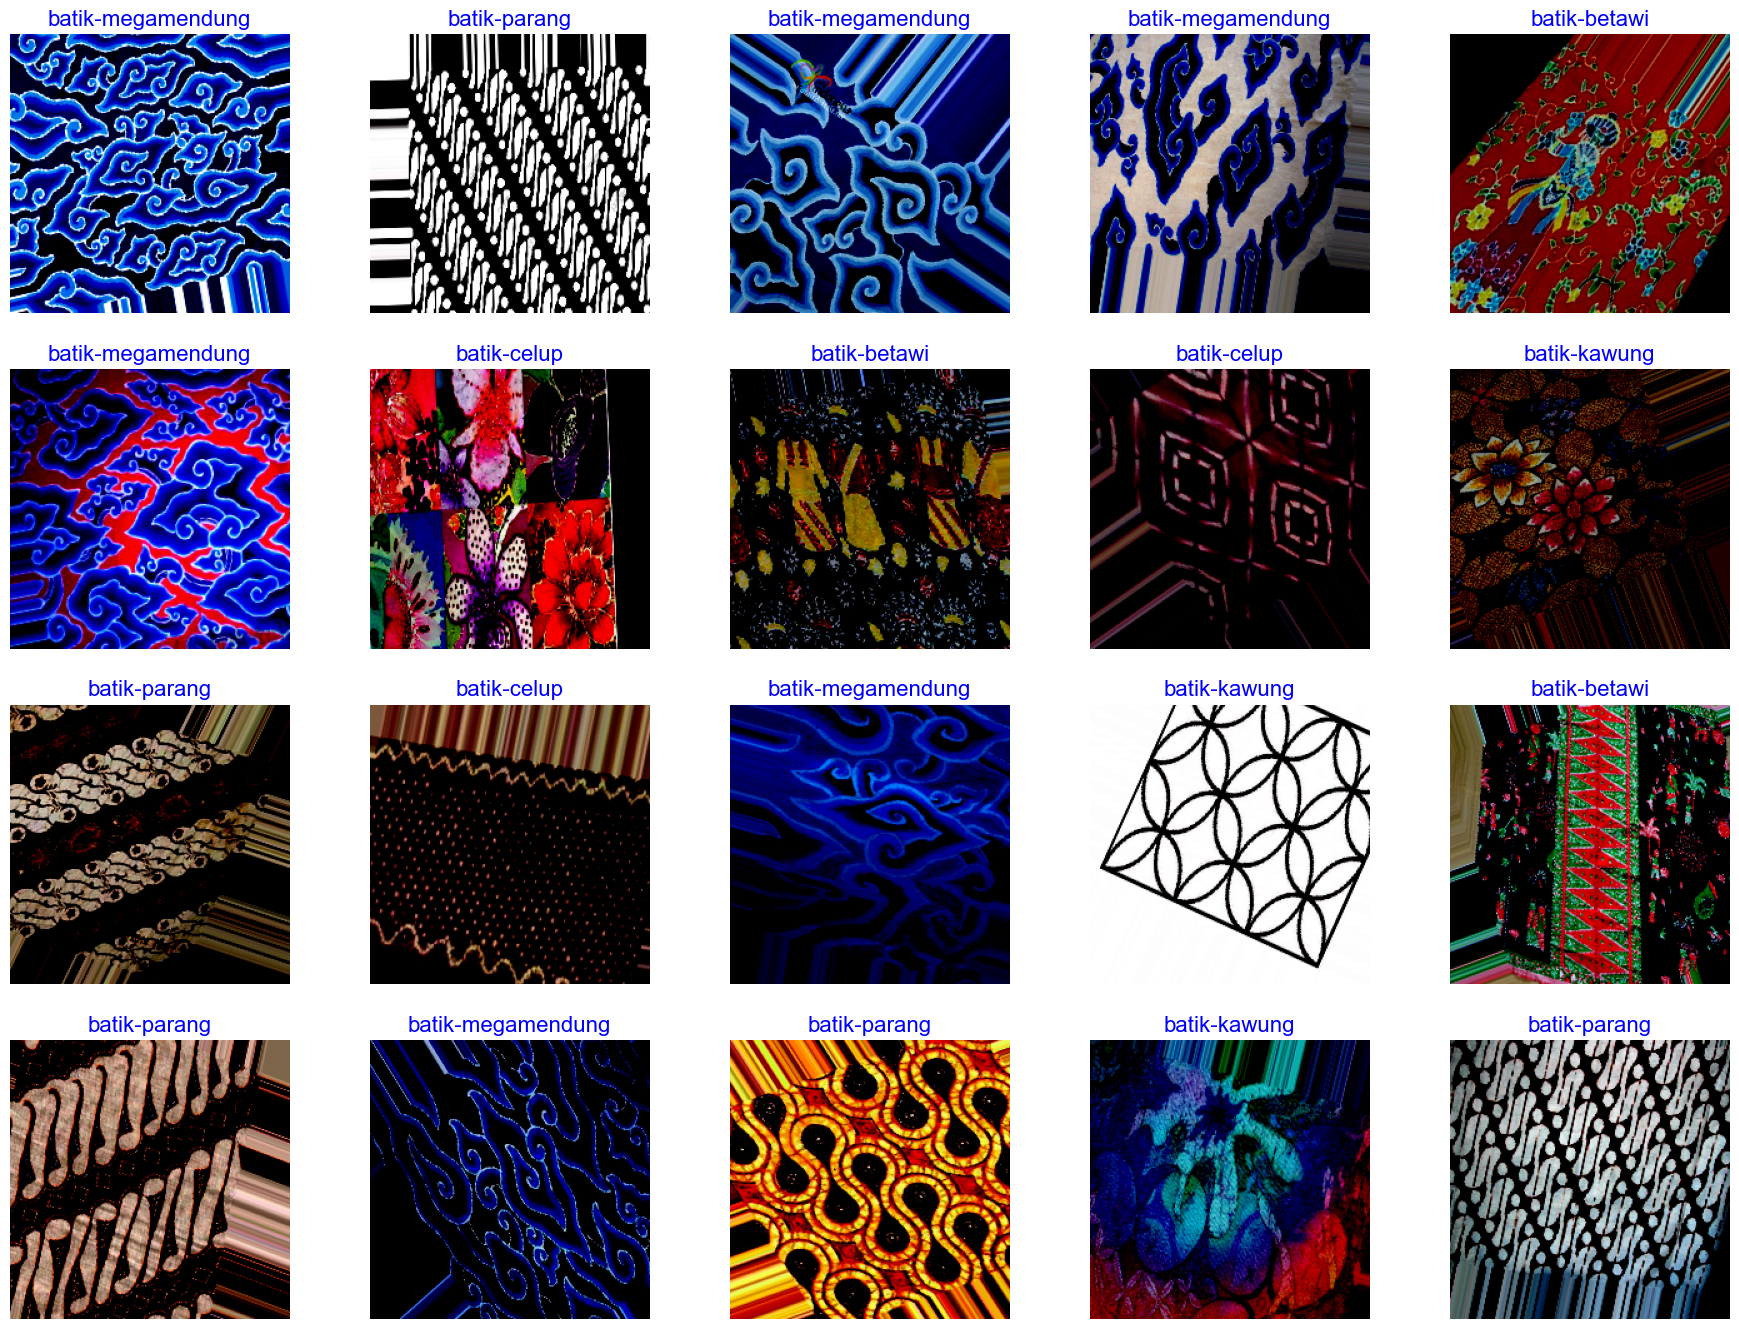

In [135]:
show_image_samples(train_gen)

In [136]:
def print_in_color(txt_msg, fore_tupple, back_tupple,):
    # prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    # text_msg is the text, fore_tupple is foreground color tupple (r, g, b), back_tupple is background tupple(r, g, b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush = True)
    print('\33[0m', flush = True) # returns default print color to back to black

In [137]:
base_model = tf.keras.applications.MobileNetV2(include_top = False, weights = "imagenet", input_shape = img_shape)
base_model.trainable = False

#MobileNetV2
model_MobileNetV2 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = 3, activation = 'relu', strides = 1),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(class_count, activation = "softmax")
])

model_MobileNetV2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [138]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_30[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [139]:
model_MobileNetV2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_79 (Conv2D)          (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 3, 3, 32)          0         
                                                                 
 flatten_29 (Flatten)        (None, 288)               0         
                                                                 
 dense_38 (Dense)            (None, 5)               

In [140]:
model_name = 'MobileNetV2'
history_MobileNetV2 = model_MobileNetV2.fit(x = train_gen, epochs = 100, verbose = 1, validation_data = valid_gen, initial_epoch = 0)

Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 2.3170 - accuracy: 0.3665 - val_loss: 0.9846 - val_accuracy: 0.6667
Epoch 2/100
10/10 [==============================] - 9s 924ms/step - loss: 0.9800 - accuracy: 0.6021 - val_loss: 0.6782 - val_accuracy: 0.7917
Epoch 3/100
10/10 [==============================] - 9s 901ms/step - loss: 0.9376 - accuracy: 0.6754 - val_loss: 0.8713 - val_accuracy: 0.6250
Epoch 4/100
10/10 [==============================] - 9s 907ms/step - loss: 0.7454 - accuracy: 0.7487 - val_loss: 0.6511 - val_accuracy: 0.7917
Epoch 5/100
10/10 [==============================] - 9s 905ms/step - loss: 0.6220 - accuracy: 0.7801 - val_loss: 0.7027 - val_accuracy: 0.7500
Epoch 6/100
10/10 [==============================] - 9s 924ms/step - loss: 0.4798 - accuracy: 0.8534 - val_loss: 0.6682 - val_accuracy: 0.7083
Epoch 7/100
10/10 [==============================] - 9s 899ms/step - loss: 0.5422 - accuracy: 0.8168 - val_loss: 0.4565 - val_accuracy: 0.7917
E

In [141]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

MobileNetV2-v1


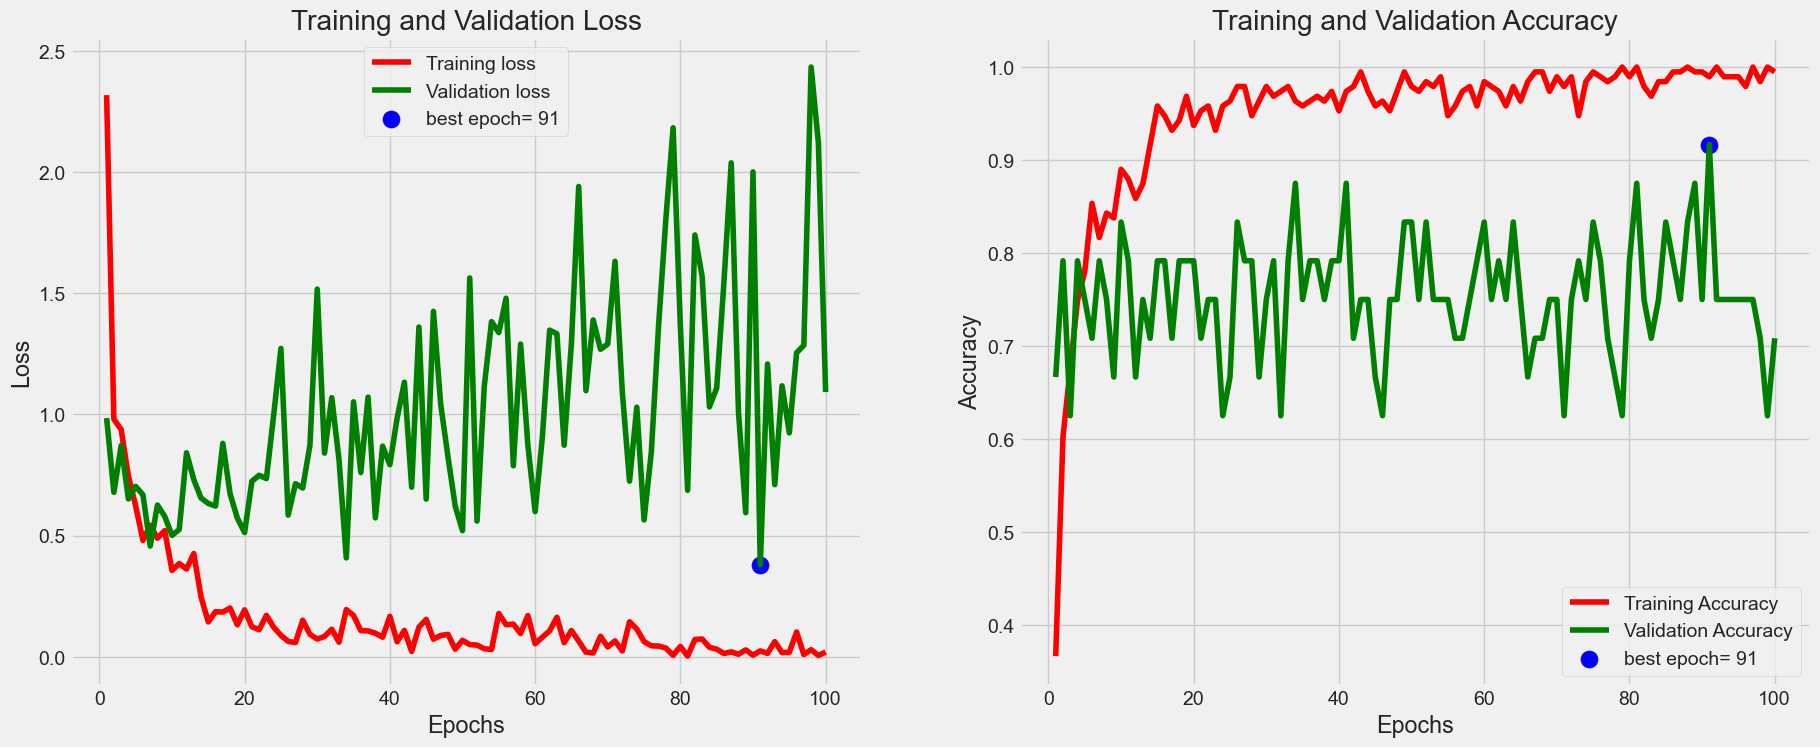

1/1 [==============================] - 1s 1s/step - loss: 2.8002 - accuracy: 0.8333
accuracy on the test set is 83.33 %



In [147]:
save_dir=r'D:/Teteh/KULIAH S1/SEMESTER 6/Bangkit 2023/Capstone Project/'
subject='Batik'

# MobileNetV2
model_name = 'MobileNetV2-v1'
print(model_name)
tr_plot(history_MobileNetV2, 0)
acc_MobileNetV2 = model_MobileNetV2.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc_MobileNetV2:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc_MobileNetV2)[:str(acc_MobileNetV2).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model_MobileNetV2.save(save_loc)

In [148]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

1/1 [==============================] - 1s 1s/step


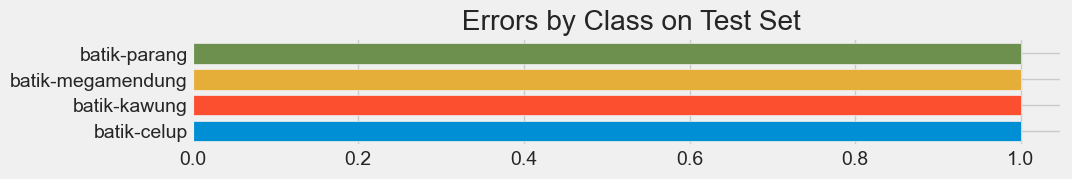

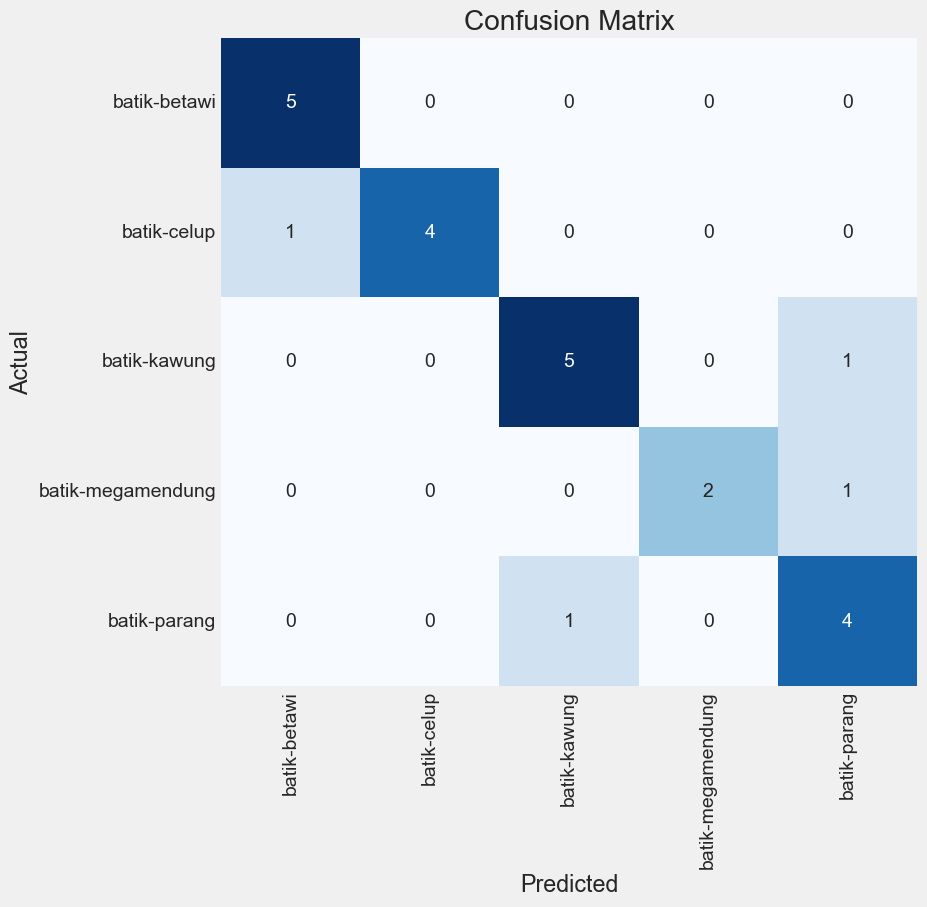

Classification Report:
----------------------
                    precision    recall  f1-score   support

     batik-betawi       0.83      1.00      0.91         5
      batik-celup       1.00      0.80      0.89         5
     batik-kawung       0.83      0.83      0.83         6
batik-megamendung       1.00      0.67      0.80         3
     batik-parang       0.67      0.80      0.73         5

         accuracy                           0.83        24
        macro avg       0.87      0.82      0.83        24
     weighted avg       0.85      0.83      0.83        24



In [149]:
print_code=0
preds=model_MobileNetV2.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, subject)  